# Meta-Analysis and Quantitative Review of Interpersonal Neural Synchrony fMRI and fNIRS Studies

This notebook guides through the majority of analyses reported in our meta-analysis and quantitative review of interpersonal neural synchrony (INS) fMRI and fNIRS studies. Meta-analysis functions are drawn from the [Neuroimaging Meta-Analysis Research Environment (NiMARE) 0.0.9](https://nimare.readthedocs.io/) package, image manipulation functions from Nilearn 0.8.0, and performed in a Python 3.8.8 environment on a macOS 11.5.2 system. Custom functions are located in ['ma_fun.py'](src/ma_fun.py), ['fnirs_fun.py'](src/fnirs_fun.py), and ['help_fun.py'](src/help_fun.py).  
Resting-state functional connectivity analyses were conducted separately in a MATLAB (2021b) environment. For description of output files, see [data README](data/README.md).

**Required libraries:**  
[NiMARE](https://nimare.readthedocs.io/), [Nilearn](https://nilearn.github.io/), [AtlasReader](https://github.com/miykael/atlasreader), [NumPy](https://numpy.org/), [pandas](https://pandas.pydata.org/), [SciPy](https://scipy.org/), [matplotlib](https://matplotlib.org/).

**Overview:**  
1. [Primary activation likelihood estimation of fMRI studies (ALE)](#ale)
2. [Validation of ALE findings (leave one experiment out [LOEO], fail-safe-N [FSN])](#loeo)
3. [Task-based and resting-state connectivity (MACM & RSFC)](#conn)
4. [Functional and spatial decoding (forward & reverse inference, network/ROI distributions](#deco)
5. [Quantitative summary of fNIRS hyperscanning results](#fnirs)

#### Libraries and base variables

In [1]:
from os.path import join, abspath, dirname
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn.image import load_img, index_img, resample_img, math_img, iter_img
from nilearn.masking import intersect_masks
from nilearn.plotting import plot_matrix, plot_connectome
from IPython.display import Image, display

from src.help_fun import csv_to_nimare_ds, nimare_ds_to_sleuth, correlate_volumes_via_atlas, get_size_of_rois, plot_gb, plot_surface_roi
from src.ma_fun import run_ale, loeo, exp_contributions, fsn, rel_abs_distributions
from src.fnirs_fun import fnirs_result

# working directory
cp = abspath('MAsync_main.ipynb')
wd = join(dirname(cp), 'data')

# NiMARE ALE settings
n_perm = 5000 # run N = 5000 permutations
v_thr = 0.001 # voxel-level threshold p < 0.001
n_core = -1 # use all CPU cores

# Load results of INS fMRI studies into a NiMARE dataset. 
# If multiple contrasts per study are given, concatenate data into one experiment.
ds = csv_to_nimare_ds(file   =join(wd, 'ale_coordinates.csv'), # spreadsheed with study info
                      exp_var='publication', # column indicating experiment names
                      n_var  ='n', # column indicating sample sizes
                      con_var='contrasts', # column indicating contrast names
                      spa_var='space', # column indicating coordinate space
                      x_var  ='x', y_var='y', z_var='z', # columns indicating coordinates
                      single_contrasts=False) # concatenate contrasts per experiment

/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


Converting TAL coordinates from Silbert 2014 to MNI.
Converting TAL coordinates from Stephens 2010 to MNI.
Converting TAL coordinates from Wang 2021 pp to MNI.
Concatenating coordinates over multiple contrasts per study.
Imported data from 22 studies, 740 participants, and 313 foci as 22 unique contrasts into NiMARE dataset.


## 1. Primary Activation Likelihood Estimation of fMRI studies <a class="anchor" id="ale"></a>

The main ALE analysis in our study. We included coordinates from all fMRI studies that assessed inter-brain synchrony using correlational approaches and reported coordinates in standardized 3D space. Additionally, we requested data directly from the authors if no coordinates were reported. 

Extracted coordinates are stored in a csv file and read into a NiMARE database. Coordinates reported in Talairach space are transformed to MNI space using the Lancaster-transform as implemented in NiMARE ([Lancaster et al., 2007](http://doi.org/10.1002/hbm.20345)). 
The function to calculate ALEs ([Turkeltaub et al. 2002](https://doi.org/10.1006/nimg.2002.1131), [2012](https://doi.org/10.1002/hbm.21186), [Eickhoff et al., 2012](https://doi.org/10.1016/j.neuroimage.2011.09.017)) takes a NiMARE database or a Sleuth text-file as input and follows the [NiMARE ALE workflow](https://github.com/neurostuff/nimare/blob/b5082c8/nimare/workflows/ale.py#L16). Activation maps for each experiment are modeled in MNI152 space at 2mm isotropic resolution. As recommended ([Eickhoff et al., 2016](https://doi.org/10.1016/j.neuroimage.2016.04.072)), the ALE map is thresholded at p < .001 (uncorrected) at voxel-level and p < .05 (FWE-corrected) at cluster-level. Cluster-significance is determined by comparison of resulting cluster sizes with a null-distribution of maximum cluster sizes generated by random relocation of foci within a grey matter template. NiMARE p-, z- and ALE-maps as well as thresholded & binarized volumes, and cluster information tables are stored.  
We repeat the ALE analysis with a more lenient voxel-threshold of p < 0.01 to increase sensitivity for potential weak effects.

Results indicate a single cluster showing meta-analytic consistency across included studies located at posterior superior/medial temporal gyrus, often considered as a part of the right temporoparietal junction (rTPJ). Using a more lenient voxel-level threshold, this cluster gains in size.

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data

Calculating ALE on 22 experiments with 22 contrasts, 740 participants and 313 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/ale

Calculating ALE on 22 experiments with 22 contrasts, 740 participants and 313 foci.
Thresholding: voxel-level p < 0.01 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/ale



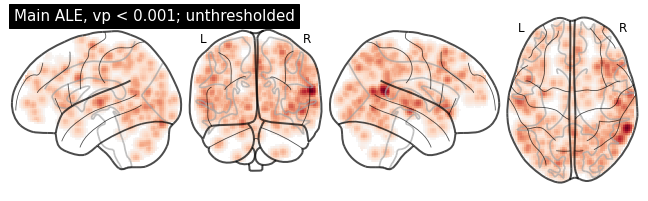

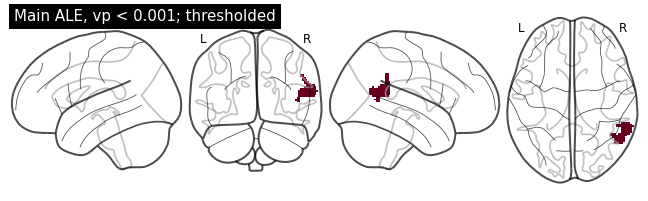

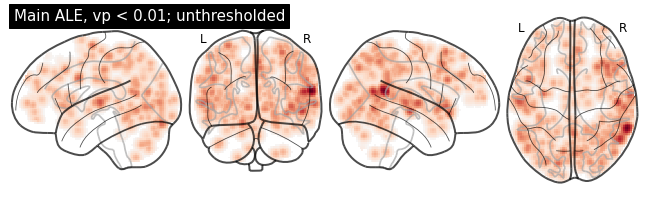

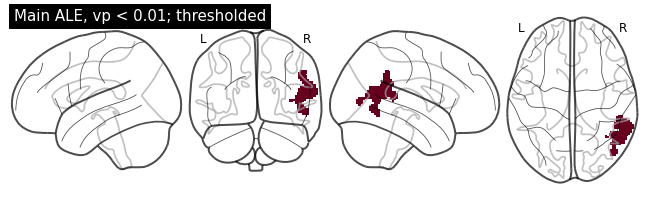

In [2]:
# Perform main ALE
_ = run_ale(data    =ds, # NiMARE dataset
            work_dir=join(wd, 'ale'), pref='ale_', # path and prefix of stored files
            vox_thr =v_thr, # voxel-level threshold
            n_perm  =n_perm, # number of iterations for FWE correction
            n_core  =n_core, # number of computing cores to use
            glassbrain_title='Main ALE, vp < 0.001') # title of results plot
# Repeat with more lenient voxel-level thresholding (p < 0.01)
_ = run_ale(data=ds, work_dir=join(wd, 'ale'), pref='ale01_', vox_thr=0.01, 
            n_perm=n_perm, n_core=n_core, glassbrain_title='Main ALE, vp < 0.01')

#### Prepare volumes for following analyses and plot result on surface

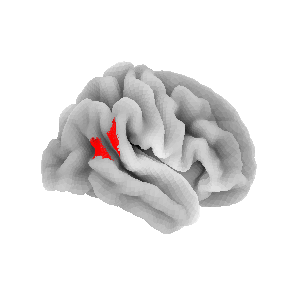

In [3]:
# binarized rTPJ-cluster
ale_rTPJ_bin = load_img(join(wd, 'ale', 'ale_thresh_bin.nii.gz'))
ale_rTPJ_bin.to_filename(join(wd, 'ale_rTPJ_bin.nii.gz'))
# for MACM/Sleuth analyses, clusters need to have a voxel-size of 1x1x1 cm^3.
ale_rTPJ_bin_forSleuth = resample_img(ale_rTPJ_bin, np.diag([1,1,1]), interpolation='nearest')
ale_rTPJ_bin_forSleuth.to_filename(join(wd, 'macm', 'ale_rTPJ_bin_forSleuth.nii.gz'))
# for RSFC analyses, the CONN toolbox requires uncompressed volumes 
ale_rTPJ_bin.to_filename(join(wd, 'rsfc', 'ale_rTPJ_bin_forCONN.nii'))

# plot rTPJ cluster on surface
plot_surface_roi(ale_rTPJ_bin)

## 2. Validation of ALE findings <a class="anchor" id="loeo"></a>

### Leave one experiment out

We control our findings for the influence of single experiments or studies by systematically rerunning the main ALE analysis while excluding one experiment at a time (LOEO). To evaluate the results, we calculate the conjunction between all binary cluster maps resulting from the LOEO ALEs. Conjunction maps are calculated by simple element-wise multiplication of the thresholded and binarized 3D volumes ([Nichols et al, 2005](https://doi.org/10.1016/j.neuroimage.2004.12.005)).

The rTPJ cluster proofed stable against the influence of single experiments.


Calculate ALE without experiment 1 Anders 2011-pseudo: predict perciever's from sender's activity
Calculating ALE on 21 experiments with 21 contrasts, 728 participants and 306 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 2 Bilek 2015 1-(dyad-ISC during interaction > no interaction) > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 714 participants and 311 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 3 Bilek 2015 2-(dyad-ISC during interaction > no interaction) > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 690 participants and 312 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 4 Dikker 2014-pseudo: speaker/listener-ISC
Calculating ALE on 21 experiments with 21 contrasts, 730 participants and 312 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 5 Koike 2016 1 3 +  2019b-2016 1  dyad-ISC during mutual gaze after JA (same partner)
Calculating ALE on 21 experiments with 21 contrasts, 676 participants and 293 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 6 Koike 2016 2-dyad-ISC during mutual gaze without JA task
Calculating ALE on 21 experiments with 21 contrasts, 710 participants and 312 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 7 Koike 2019a-dyad-ISC during mutual gaze with live video > delayed video
Calculating ALE on 21 experiments with 21 contrasts, 712 participants and 307 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 8 Kostorz 2020-pseudo: intructor-observer-ISC across conditions  > 0
Calculating ALE on 21 experiments with 21 contrasts, 711 participants and 286 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 9 Liu 2021 + 2021 pp-pseudo: speaker/listener-ISC, 0 sec time-lag
Calculating ALE on 21 experiments with 21 contrasts, 707 participants and 300 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 10 Miyata 2021-dyad-ISC during imitation > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 708 participants and 307 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 11 Saito 2010-dyad-ISC during JA > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 702 participants and 310 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 12 Salazar 2021-dyad-ISC during JAct > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 696 participants and 305 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 13 Shaw 2018-dyad-ISC during ultimatum game > control task
Calculating ALE on 21 experiments with 21 contrasts, 702 participants and 301 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 14 Shaw 2020-dyad-ISC during coop/comp > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 686 participants and 289 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 15 Silbert 2014-pseudo: speaker/listener-ISC > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 726 participants and 291 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 16 Smirnov 2019-pseudo: speaker/listener-ISC > random correlation
Calculating ALE on 21 experiments with 21 contrasts, 722 participants and 279 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 17 Spiegelhalder 2014-dyad-ISC during speak/listen > control, no time-lag
Calculating ALE on 21 experiments with 21 contrasts, 718 participants and 304 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 18 Spilakova 2020-dyad-ISC during cooperation > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 702 participants and 284 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 19 Stephens 2010-pseudo: speaker-listener-ISC > listener-listener-ISC
Calculating ALE on 21 experiments with 21 contrasts, 726 participants and 293 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 20 Wang 2021 pp-dyad-ISC during coop/comp
Calculating ALE on 21 experiments with 21 contrasts, 674 participants and 304 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 21 Xie 2020-dyad-ISC during collaborative drawing > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 704 participants and 271 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo


Calculate ALE without experiment 22 Yoshioka 2021-task-dependent dyad-ISC during JA > random-ISC
Calculating ALE on 21 experiments with 21 contrasts, 696 participants and 296 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/loeo

Conjunction volume saved to /Users/leonlotter/MAsync/git/data/loeo/loeo_conjunction.nii.gz


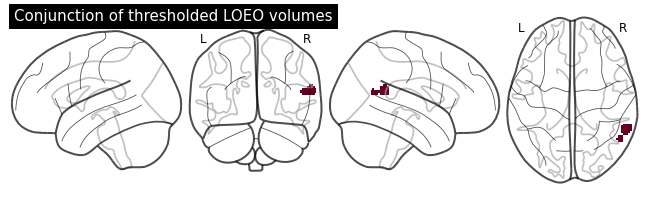

In [4]:
# Custom function peforming N(experiments) ALEs, while leaving out one experiment at a time.
loeo_res, _ = loeo(ds=ds, v_thr=v_thr, n_perm=n_perm, n_core=n_core, # ALE settings
                   save_dir=join(wd, 'loeo'), prefix='loeo_', # path and prefix for stored files
                   conj_save=join(wd, 'loeo', 'loeo_conjunction.nii.gz')) # path for stored conjunction volume

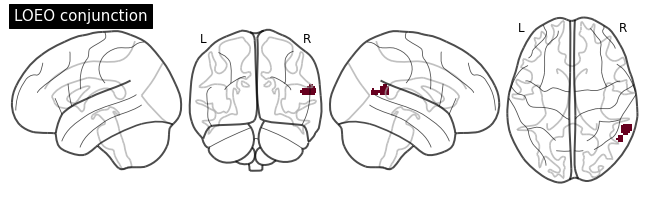

In [5]:
# Plot LOEO conjunction volume
plot_gb(join(wd, 'loeo', 'loeo_conjunction.nii.gz'), title='LOEO conjunction')

### Contribution of single experiments

Following Eickhoff et al. ([2016](https://doi.org/10.1016/j.neuroimage.2016.04.072)), we assess the average contribution of each experiment to the resuling ALE clusters based on the LOEO ALEs. For each experiment, we calculate the ratio of the averaged ALE values within the cluster with and without the current experiment.

Results show that 14 of 22 experiments (~64%) contributed relevantly to the rTPJ cluster with a maximum contribution of ~16%.

In [16]:
# Custom function to calculate experiment-wise contributions (in percent) to a given cluster
contributions = exp_contributions(
    ale_ALL =join(wd, 'ale', 'ale_stat.nii.gz'), # ALE value volume, all experiments included
    ale_EXP =[res.get_map('stat') for res in loeo_res], # list of ALE value volumes from LOEO analyses (s.o.)
    cl_masks=[ale_rTPJ_bin], # binarized cluster(s)
    exp_ids =ds.ids) # list of experiment IDs
contributions.to_csv(join(wd, 'loeo', 'loeo_contributions.csv'), float_format='%f', index=False) # save table
print(round(contributions['cl1_contr_prc'], 1)) # print table
print(len(contributions[contributions['cl1_contr_prc'] > 0.5])) # print number of contributing studies

Calculated experiment-wise contributions of 22 experiments to 1 clusters.
0      0.0
1      5.8
2      9.1
3      0.0
4     12.3
5      2.0
6      0.0
7      8.7
8      0.0
9      0.8
10     0.0
11     0.0
12     0.0
13     7.4
14    10.9
15     0.0
16     7.3
17    15.6
18     8.7
19     0.8
20     6.0
21     3.9
Name: cl1_contr_prc, dtype: float64
14


### Robustness against publication bias

[Acar et al. (2018)](https://doi.org/10.1371/journal.pone.0208177) proposed a method to assess ALE results for the influence of the "file drawer effect" by adding a number of noise experiments to the original sets of coordinates and evaluating their influence on a certain significant cluster. Properties of noise studies (sample-sizes, number of coordinates) are drawn from the "true" dataset. Noise foci are sampled outside of the brain quadrant where the "true" cluster (rTPJ) is located to reduce the chance of noise foci contributing to the cluster. The FSN is approximated by iteratively testing the inclusion of low and high numbers of noise studies starting at predefined points ("fsn_range") that we determined from the number of contributing studies (14 and 118, the latter would result in a minimum contribution of 14/(118+22) = 10% of studies when noise studies are included).

Results show a FSN of 37, meaning that up to approximately 37 experiments reporting coordinates in different brain locations can be added to the ALE analysis before the rTPJ cluster looses significance. Considering the very low chance that more than such a number of fMRI studies would "remain in the file drawer", this result indicates robustness of the rTPJ finding against publication bias.

In [102]:
# Custom python implementation of the FSN-method by Acar et al. Only results volumes of the final run are stored.
    # warnings regarding "pixdim" (fetching of template for MNI coordinate sampling) and 
fsn_tab, _, ds_noise = fsn(ds       =ds, # 'true' NiMARE dataset
                           cl_true  =[ale_rTPJ_bin], # true clusters to check on 
                           fsn_range=[14, 118], # starting points to search for exact FSN
                           save_dir =join(wd, 'fsn'), pref='fsn_', # path and prefix for stored files
                           n_perm   =n_perm, v_thr=v_thr, # ALE settings
                           seed     =987654321) # seed to make noise study generation reproducible

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1



Cluster 1:

FSN step 1: Add minimum 14 noise studies.

Calculating ALE on 36 experiments with 36 contrasts, 1178 participants and 484 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/pandas/core/missing.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x
INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster significant, proceed.

FSN step 2: Add maximum 118 noise studies.

Calculating ALE on 140 experiments with 140 contrasts, 4787 participants and 1814 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, no significant clusters! NiMARE results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster not significant, proceed.

FSN step 3+0: Add 66 noise studies.

Calculating ALE on 88 experiments with 88 contrasts, 2973 participants and 1144 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, no significant clusters! NiMARE results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster not significant.
New min FSN = 14, new max FSN = 66, new N = 40.

FSN step 3+1: Add 40 noise studies.

Calculating ALE on 62 experiments with 62 contrasts, 2122 participants and 770 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, no significant clusters! NiMARE results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster not significant.
New min FSN = 14, new max FSN = 40, new N = 27.

FSN step 3+2: Add 27 noise studies.

Calculating ALE on 49 experiments with 49 contrasts, 1677 participants and 640 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster significant.
New min FSN = 27, new max FSN = 40, new N = 33.

FSN step 3+3: Add 33 noise studies.

Calculating ALE on 55 experiments with 55 contrasts, 1852 participants and 713 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster significant.
New min FSN = 33, new max FSN = 40, new N = 36.

FSN step 3+4: Add 36 noise studies.

Calculating ALE on 58 experiments with 58 contrasts, 1968 participants and 732 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster significant.
New min FSN = 36, new max FSN = 40, new N = 38.

FSN step 3+5: Add 38 noise studies.

Calculating ALE on 60 experiments with 60 contrasts, 2008 participants and 746 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, no significant clusters! NiMARE results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster not significant.
New min FSN = 36, new max FSN = 38, new N = 37.

FSN step 3+6: Add 37 noise studies.

Calculating ALE on 59 experiments with 59 contrasts, 1994 participants and 745 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/fsn

Cluster significant.
New min FSN = 37, new max FSN = 38, new N = 37.
Looping out after 7 iterations, FSN exactly determined for the given set of noise studies.

Cluster 1: FSN finished: FSN (~)= 37 (min = 37, max = 37)


  cluster  appr_fsn  min_fsn  max_fsn
0     cl1        37       37       37
Sleuth foci file saved to: /Users/leonlotter/MAsync/git/data/fsn/noise_studies.txt


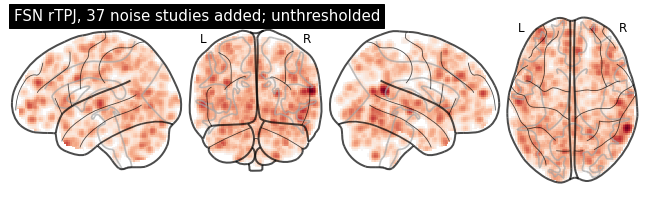

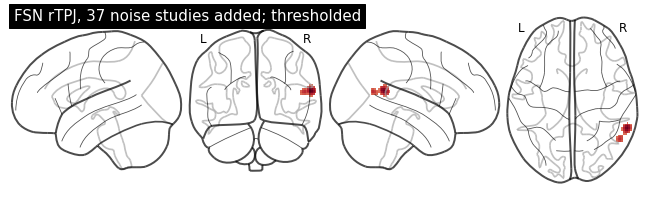

In [103]:
# show and save result and plot volumes with FSN noise studies added
print(fsn_tab) # print results
fsn_tab.to_csv(join(wd, 'fsn', 'fsn_result.csv'), index=False) # save table
nimare_ds_to_sleuth(ds_noise, join(wd, 'fsn', 'noise_studies.txt')) # save Sleuth text file
plot_gb(join(wd, 'fsn', 'fsn_cl1_z.nii.gz'), # print unthresholded
        title='FSN rTPJ, {} noise studies added; unthresholded'.format(fsn_tab.appr_fsn[0]))
plot_gb(join(wd, 'fsn', 'fsn_cl1_thresh_z.nii.gz'), # print thresholded volume
        title='FSN rTPJ, {} noise studies added; thresholded'.format(fsn_tab.appr_fsn[0]))

## 3. Task-related and task-free connectivity <a class="anchor" id="conn"></a>

### Meta-analytic connectivity modelling

Using the robust rTPJ cluster as seed, we calculate a network of task-related co-activation based on the brainmap database ([Langner et al., 2014](https://doi.org/10.1016/j.neuroimage.2014.06.007)).  
Via [Sleuth](http://brainmap.org/sleuth/), we search the BrainMap database for "normal mapping" studies in healthy subjects reporting activations within the ALE cluster. Foci coordinates from included BrainMap studies are manually exported from Sleuth to a text file. We perform a single ALE on these coordinates (settings as above, voxel-level threshold p < 0.001). 

We find a task-related network with mainly cortical clusters located in bilateral TPJ-related regions ("lTPJ" & "rTPJ"), bilateral inferior/ middle frontal gyrus and insula ("rIns" & "lIns"), and middle cingulate cortex/ medial frontal gyrus ("MCC"). Two subcortical clusters are placed on right Thalamus and Pallidum ("rTh" & "rPal").

In [7]:
macm_sleuth_file = join(wd, 'macm', 'sleuth_rTPJ_coordinates.txt') 
# perform MACM ALE
_ = run_ale(data=macm_sleuth_file, work_dir=join(wd, 'macm'), pref='macm_rTPJ_', 
            vox_thr=v_thr, n_perm=n_perm, n_core=n_core, print_glassbrain=False)

Calculating ALE on 140 experiments with 142 contrasts, 2215 participants and 2667 foci.
Thresholding: voxel-level p < 0.001 uncorrected, cluster-level p < 0.05 FWE-corrected, 5000 permutations.


INFO:nimare.correct:Using correction method implemented in Estimator: nimare.meta.cbma.ale.ALE.correct_fwe_montecarlo.


  0%|          | 0/5000 [00:00<?, ?it/s]

INFO:nimare.meta.cbma.base:Using null distribution for voxel-level FWE correction.


ALE completed, significant clusters found. Results saved to: /Users/leonlotter/MAsync/git/data/macm



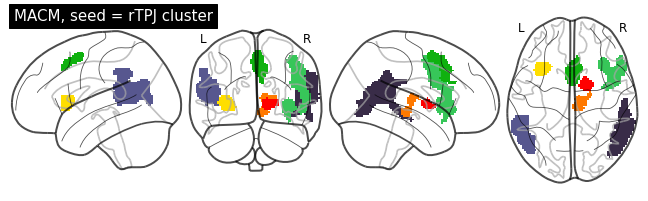

In [8]:
# copy indexed and binary MACM volumes to main folder
macm_rTPJ_idx = load_img(join(wd, 'macm', 'macm_rTPJ_thresh_idx.nii.gz'))
macm_rTPJ_idx.to_filename(join(wd, 'macm_rTPJ_idx.nii.gz'))
macm_rTPJ_bin = load_img(join(wd, 'macm', 'macm_rTPJ_thresh_bin.nii.gz'))
macm_rTPJ_bin.to_filename(join(wd, 'macm_rTPJ_bin.nii.gz'))
# prepare data for RSFC analyses with CONN (see below)
macm_rTPJ_idx.to_filename(join(wd, 'rsfc', 'macm_rTPJ_idx_forCONN.nii'))
macm_labels = pd.DataFrame([(1,'rTPJ'), (2,'lTPJ'), (3,'rIFG'), (4,'rMCC'), (5,'lIns'), (6,'rTh'), (7,'rPal')])
macm_labels.to_csv(join(wd, 'rsfc', 'macm_rTPJ_idx_forCONN.csv'), index=False, header=None)
# plot MACM result
plot_gb(macm_rTPJ_idx, title='MACM, seed = rTPJ cluster', col='videen_style')

#### Spatial correlation between ALE and MACM maps

We further evaluate whether the ALE and MACM results emerged from a spatial "activation" pattern that is present in both sets of coordinates (ALE: fMRI INS studies, MACM: studies spatially associated with the ALE cluster) but, due to a lack of power, did not result in further significant clusters in case of the primary ALE. For this, we simpy correlate both unthresholded z-standardized volumes using spearman correlations. As the overall number of voxels probably exceeds the degrees of freedom present in the data, we first parcellate the volumes using a functionally defined whole-brain atlas ([Schaefer et al., 2018](https://doi.org/10.1093/cercor/bhx179); [Tian et al., 2020](https://doi.org/10.1038/s41593-020-00711-6)). For visualisation, we plot a scatter plot and mark all points that show an overlap with MACM clusters of at least 5% of each clusters size.

We see a general spatial correlation between ALE and MACM z-volumes, driven not only by higher ALE values in the rTPJ region (red) but also by lTPJ (orange), rIns (blue) and lIns (green) ROIs. 

Spearman`s r = 0.36, p = 0.0


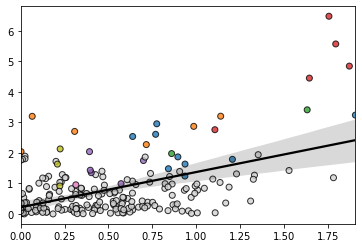

In [9]:
# load atlas and macm result (216 ROIs)
atlas = load_img(join(wd, 'atlases', 'Schaefer200-7_TianS1_2mm.nii.gz'))
labels = pd.read_csv(join(wd, 'atlases', 'Schaefer200-7_TianS1_2mm.csv'), names=['idx', 'label', 'color'])
macm_idx = load_img(join(wd, 'macm', 'macm_rTPJ_thresh_idx.nii.gz'))

# MARKER COLORS FOR SCATTER PLOT 
cl_info = get_size_of_rois(macm_idx) # get macm cluster indices and sizes
colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:purple', 'tab:green', 'tab:pink', 'tab:olive'] # cluster marker colors
labels['color'] = 'lightgrey' # non-cluster marker colors
# iterate over macm clusters
for i_cl in cl_info['idx']:
    cl_dat = macm_idx.get_fdata() # get cluster data
    cl_parcel = (cl_dat==i_cl) * atlas.get_fdata() # intersect current cluster with atlas
    cl_size = cl_info['size'][cl_info['idx'] == i_cl].values[0] # size of current cluster 
    cl_parcel_sizes = get_size_of_rois(cl_parcel) # sizes of parcel-cluster intersections
    # keep parcel-cluster intersections that make at least 5% of cluster size
    cl_parcel_thr = cl_parcel_sizes[cl_parcel_sizes['size'] >= cl_size * 0.05] 
    # set color for all parcels overlapping with the current cluster
    labels['color'][labels['idx'].isin(cl_parcel_thr['idx'])] = colors[int(i_cl)-1] 

# CORRELATION AND SCATTER PLOT
# calculate spearman correlation between unthresholded MACM & ALE z maps and plot
cor_df = correlate_volumes_via_atlas(x_img=join(wd, 'ale', 'ale_z.nii.gz'),
                                     y_img=join(wd, 'macm', 'macm_rTPJ_z.nii.gz'),
                                     atlas=atlas, method='spearman', colors=labels['color'])
cor_df.to_csv(join(wd, 'macm', 'cor_macm_ale.csv'), index=False)

# Resting-state functional connectivity
We perform ROI-to-ROI resting-state functional connectivity (RSFC) analyses on [HCP data](https://www.humanconnectome.org/study/hcp-young-adult/document/900-subjects-data-release) using the [CONN toolbox](https://doi.org/10.1089/brain.2012.0073) in MATLAB.  
**Sample**: N = 120 unrelated subjects evenly drawn from each age group and gender. N = 115 after exclusion of subjects exceding motion cut-offs.  
**Data**: S900 ICA-FIX denoised volumetric data; improved image reconstruction algorithm ("r277"); concatenated first two resting-state sessions (30 min); voxel-size 2x2x2 m^3.  
**Further processing**: Segmentation of structural volumes; Smoothing of functional volumes (6 mm FWHM); CompCor denoising; Linear detrending & bandpass filtering (0.01 - 0.08); Semipartial correlations between averaged time series of each MACM cluster.  
The [batch script](src/HCP_batch.m) for extended preprocessing is based on the HCP script provided with the CONN toolbox.   
**Statistics**: Positive-sided one-sample t-test on r-to-z-transformed semipartial correlation coefficients representing each functional connection between the 7 MACM ROIs. Significance level: Bonferroni-corrected p < 0.05 to estimate the strongest connections within the co-activation network.

We see that the MACM network is also present in resting-state data. "Direct" connections are formed between right TPJ and left TPJ as well as right Insula. The remaining regions seem to be connected indirectly.

/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:2204: UserWarning: 'adjacency_matrix' is not symmetric. A directed graph will be plotted.
  warnings.warn(("'adjacency_matrix' is not symmetric. "
/Applications/Anaconda/anaconda3/lib/python3.8/site-packages/nilearn/plotting/displays.py:101: UserWarning: No contour levels were found within the data range.
  im = getattr(ax, type)(data_2d.copy(),


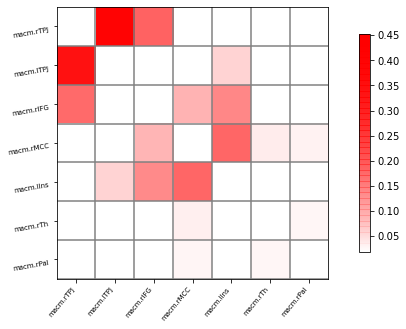

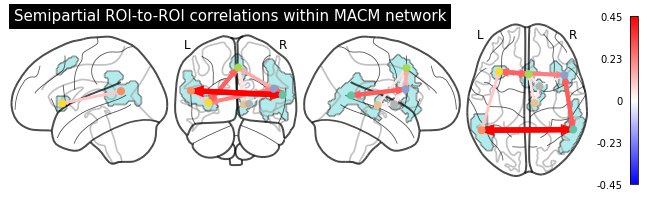

In [10]:
# load CONN result and motion data
conn_res = sp.io.loadmat(join(wd, 'rsfc', 'rsfc_macm_rTPJ_semipartial.mat'))
fwd = pd.read_csv(join(wd, 'rsfc', 'fwd.csv'))
# get connectivity data
z_all = conn_res.get('Z') # get data
z_all = z_all[:, :, (fwd['Exclude_motion']==1).to_list()] # get n=115 subjects below motion cut-offs
# get ROI coordinates
coord = np.concatenate(conn_res.get('xyz'))
coord = [c[0] for c in coord]
coord = np.array(coord)
# get ROI labels
labels = np.concatenate(conn_res.get('names'))
labels = [l[0] for l in labels]

# calculate positive-sided one-sample t-test against zero per connection
z_p, z_t = np.ones(z_all.shape[:2]), np.ones(z_all.shape[:2])
for r in range(z_p.shape[0]):
    for c in range(z_p.shape[1]):
        t, p = sp.stats.ttest_1samp(z_all[r, c, :], 0, alternative='greater')
        z_p[r, c], z_t[r, c] = p, t
        
# get mean z-value per connection across subjects
z = np.mean(z_all, 2)
# remove z-connections below Bonferroni-corrected p < 0.05
z_thresh = np.where(z_p < 0.05/42, z, 'nan').astype(float)
# save matrix 
pd.DataFrame(z_thresh).to_csv(join(wd, 'rsfc', 'rsfc_cormat.csv'), index=None, header=labels)

# plot FC matrix and connectome on glass brain 
plot_matrix(z_thresh, labels=labels, grid=True, cmap='red_transparent_full_alpha_range')
p = plot_connectome(z_thresh, coord, display_mode='lyrz', colorbar=True, 
                title='Semipartial ROI-to-ROI correlations within MACM network')
p.add_contours(join(wd, 'macm_rTPJ_bin.nii.gz'), filled=True, alpha=0.3, colors=['c'])
p.add_contours(join(wd, 'macm_rTPJ_bin.nii.gz'), colors=['k'], linewidths=0.1)

## 4. Functional and spatial decoding <a class="anchor" id="deco"></a>

### Functional decoding
Reverse and foward inference results are provided by Julia Camilleri and Simon Eickhoff. The calculation follows the BrainMap standard approach (e.g., [Laird et al., 2009](https://doi.org/10.3389/neuro.11.023.2009)). In the forward inference approach, the functional profile of a ROI is determined by identifying BrainMap behavioral domains for which the probability of finding activation in the respective ROI is significantly higher than the overall (a priori) chance across the entire database: P(Activation|Domain) > P(Activation). Binominal tests with FDR correction are used to assesss significance.  
In the reverse inference approach, the functional profile is determined by identifying the most likely behavioral domains, given activation in a particular ROI: P(Domain|Activation). This probability is derived from P(Activation|Domain) using Bayes' rule, significance is assessed using chi-squared tests (FDR-corrected).

Reoccuring functional associations emerge between the rTPJ cluster (first row, upper image) and MACM network (first row, lower image), respectively, and BrainMap domains *Social cognition*, *Observation*, and *Vision*.  

Note: not up to date, will be updated when analyses are finalized.

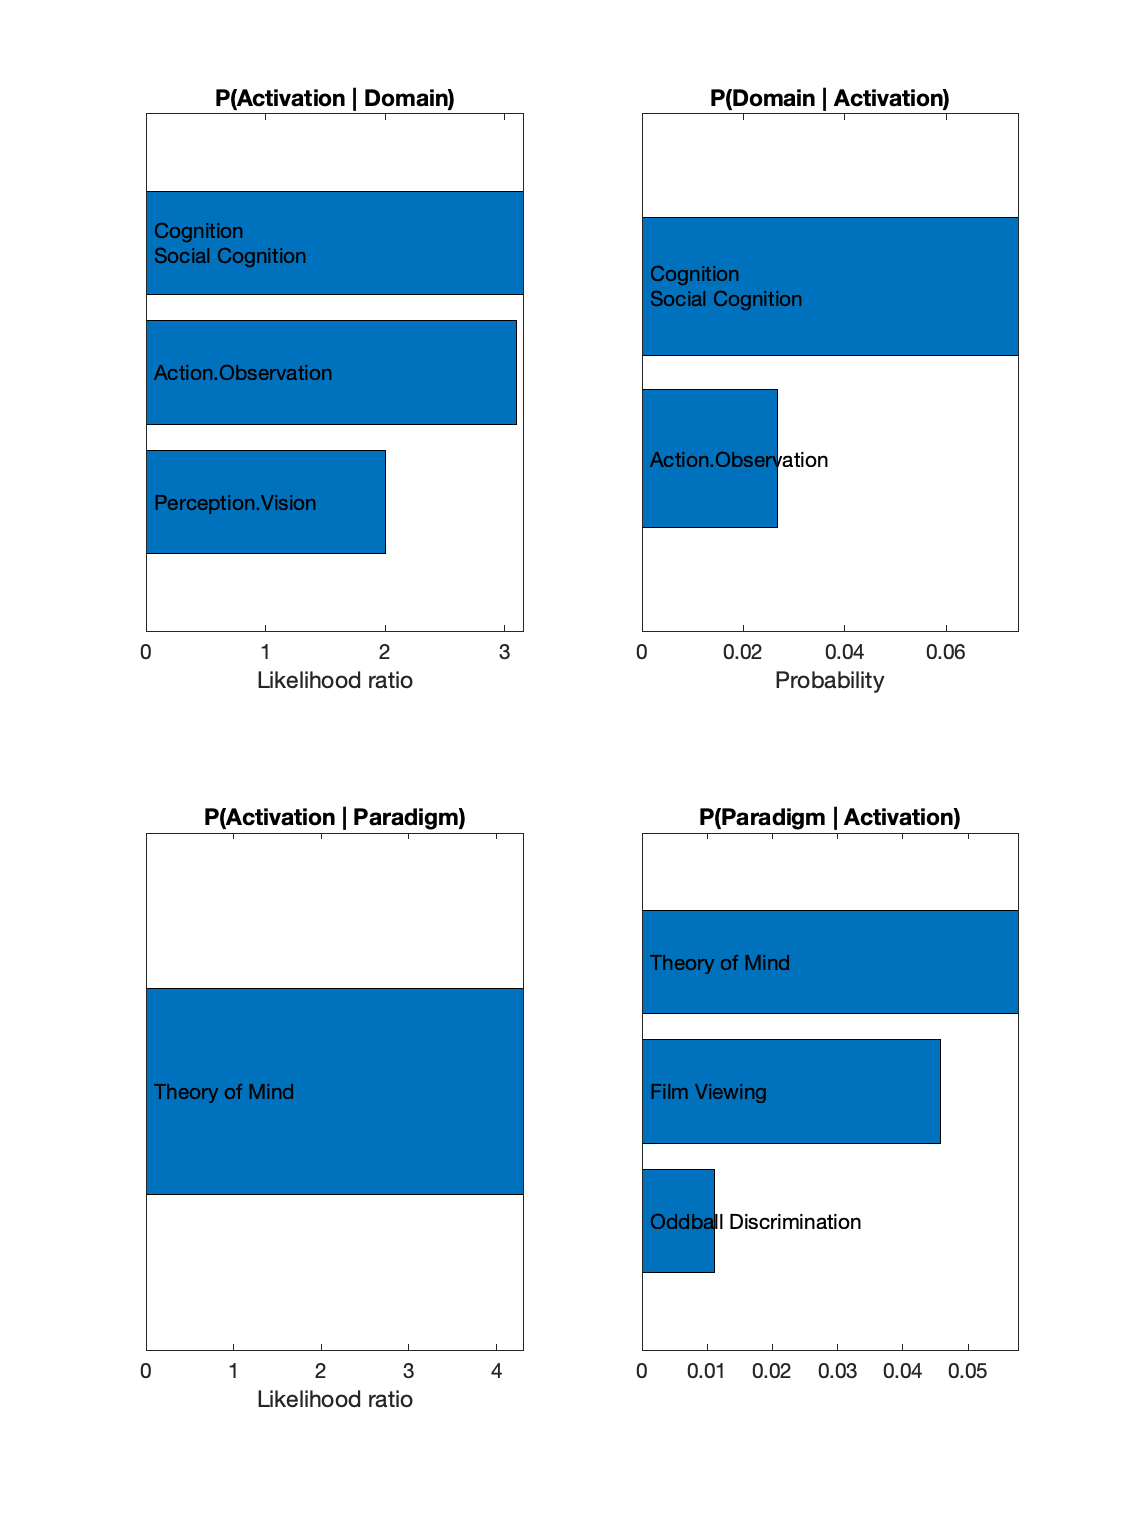

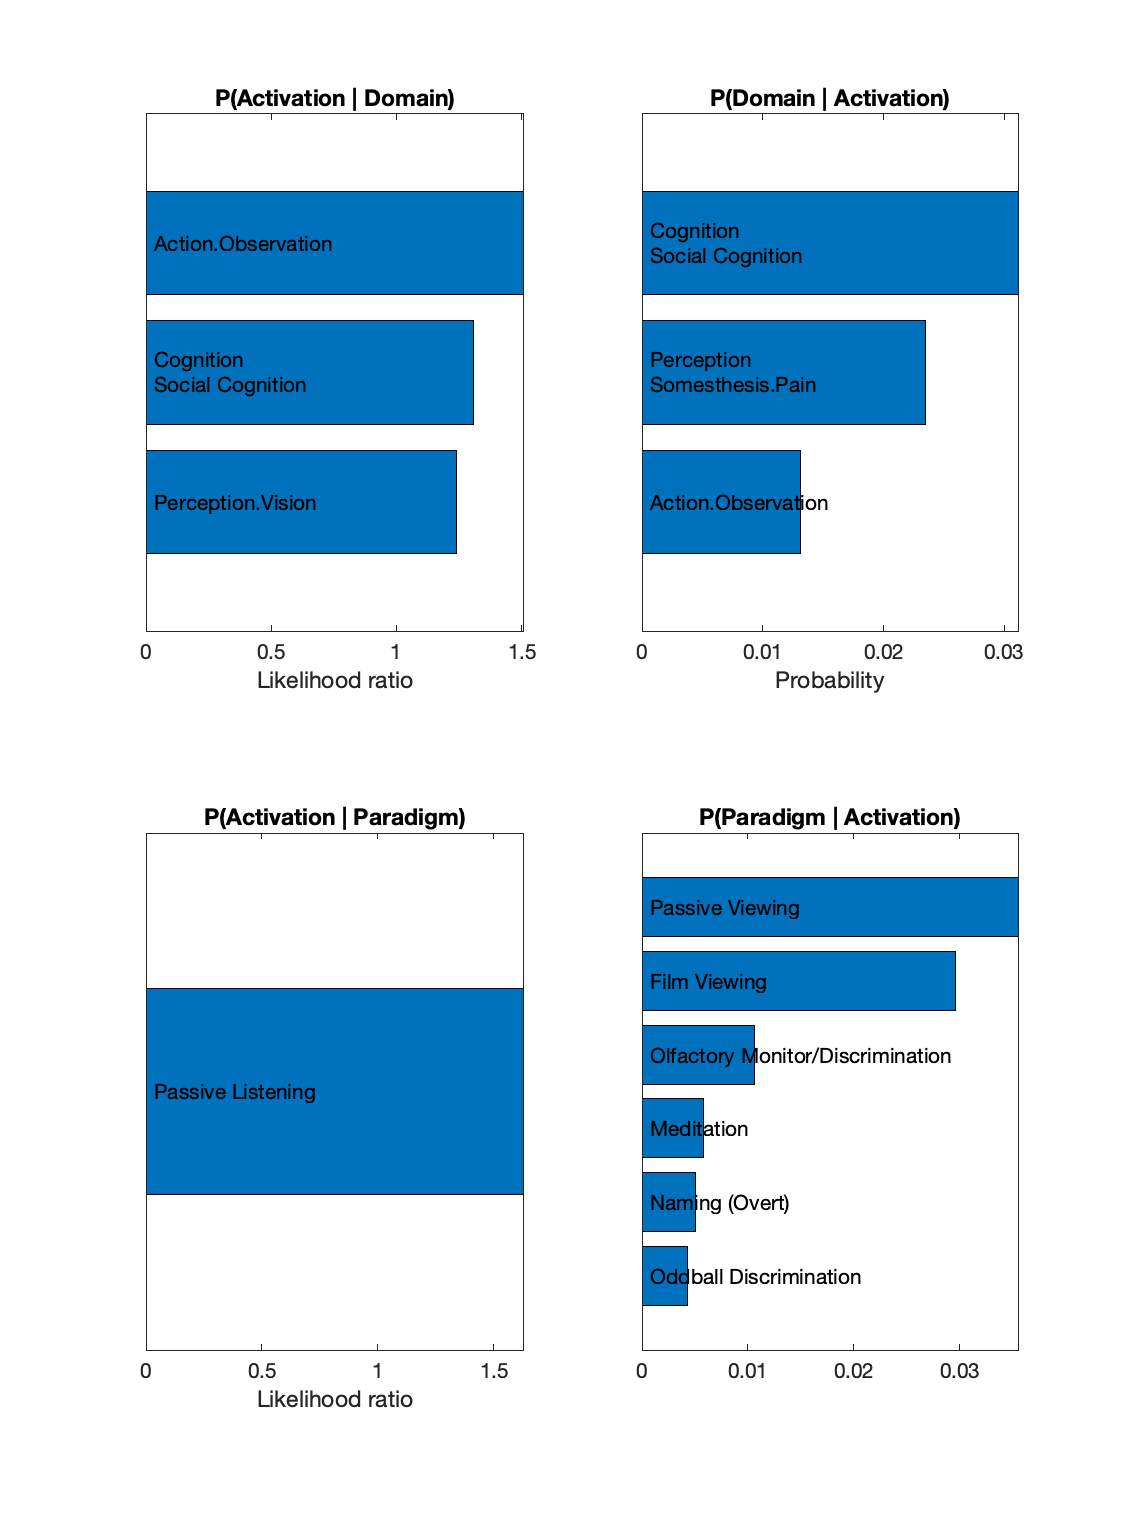

[None, None]

In [11]:
# show results, first rTPJ, then consensus network, the upper row shows associations with BrainMap domains
bd = [join(wd, 'fd', 'ale_rTPJ_FDR05.png'), join(wd, 'fd', 'conn_rTPJ_conjunction_FDR05.png')]
[display(Image(img, width=400)) for img in bd]

### Overlap with major resting-state networks
We quantify the spatial overlap of our results (rTPJ cluster, MACM network and single clusters) with seven established RSNs (cortical, striatum and thalamus) ([Yeo & Krienen et al., 2011](https://doi.org/10.1152/jn.00338.2011)) as the relative and absolute distributions of ROIs across the given networks (e.g. [Chen et al., 2018](https://doi.org/10.1007/s00429-018-1727-9)).  
The relative distribution is calculated as the proportion of "INS-voxels" within a given RSN vs. all "INS-voxels". The absolute distribution resembles the proportion of "INS-voxels" within a given RSN vs. all voxels within this RSN.

Both, rTPJ cluster and MACM network are spatially associated with the default mode network (DMN) and ventral and dorsal attention networks (VAN/DAN). The MACM network is additionally overlapping with the frontoparietal network (FPN). This is resembled in the single MACM clusters, with the TPJ clusters showing associations to DMN, VAN, & DAN, the rIns cluster (which is extending to the right precentral and inferior frontal gyri) to DMN, VAN, DAN, & FPN, and the lIns and MCC clusters to VAN & FPN.

In [12]:
# Calculate network distributions with 7 Yeo & Krienen et al., 2011 RSNs
# Input: ALE cluster, binarized MACM network, single MACM ROIs: rTPJ, lTPJ, rIns, MCC, rIns
distr_RSN_rois = ['ale_rTPJ', 'macm_rTPJ_bin', 'macm_rTPJ_rTPJ', 'macm_rTPJ_lTPJ', 
                  'macm_rTPJ_rIns', 'macm_rTPJ_MCC', 'macm_rTPJ_lIns']

distr_RSN = rel_abs_distributions(
    roi_vols    =[ale_rTPJ_bin] + [macm_rTPJ_bin] +  
                 [i for i in iter_img(index_img(join(wd, 'macm', 'macm_rTPJ_thresh_4d.nii.gz'), [0,1,2,3,4]))],
    target_vol  =load_img(join(wd, 'atlases', 'Yeo7_combined_2mm.nii.gz')), 
    target_descr=pd.read_csv(join(wd, 'atlases', 'Yeo7_combined_2mm.csv'), header=None)[1])

# save results & print tables
for d_i, d in enumerate(distr_RSN):
    print(distr_RSN_rois[d_i], '\n', d)
    d.to_csv(join(wd, 'distr', 'rsn_'+distr_RSN_rois[d_i]+'.csv'), index=False)

ale_rTPJ 
    targetNr targetName  nvox_target  nvox_roi  nvox_overlap  relDistr  absDistr
0         1         VN        22753       380             8  0.021053  0.000352
1         2        SMN        20128       380             0  0.000000  0.000000
2         3        DAN        15378       380           121  0.318421  0.007868
3         4        VAN        15153       380            62  0.163158  0.004092
4         5         LN        11958       380             0  0.000000  0.000000
5         6        FPN        20924       380             6  0.015789  0.000287
6         7        DMN        31304       380           181  0.476316  0.005782
macm_rTPJ_bin 
    targetNr targetName  nvox_target  nvox_roi  nvox_overlap  relDistr  absDistr
0         1         VN        22753      7331           597  0.081435  0.026238
1         2        SMN        20128      7331           301  0.041059  0.014954
2         3        DAN        15378      7331          1101  0.150184  0.071596
3         4  

### Overlap with rTPJ parcellation
[Bzdok et al. (2013)](https://doi.org/10.1016/j.neuroimage.2013.05.046) characterized two subunits of the right TPJ with distinct connectivity and behavioral profiles. To quantify the affiliation of our rTPJ cluster with these subunits, we calculate relative and absolute distributions within the Bzdok-ROIs.

We see that our rTPJ cluster shows overlap with both rTPJ subunits, however, with a tendency towards the posterior rTPJ. 

In [13]:
# Calculate distributions with Bzdok et al., 2011 rTPJ parcellation 
distr_TPJ = rel_abs_distributions(
    roi_vols    =[ale_rTPJ_bin],
    target_vol  =load_img(join(wd, 'atlases', 'BzdokTPJ_combined_2mm.nii.gz')), 
    target_descr=pd.read_csv(join(wd, 'atlases', 'BzdokTPJ_combined_2mm.csv'), header=None)[1])

# save results & print tables
distr_TPJ[0].to_csv(join(wd, 'distr', 'tpj_ale_rTPJ.csv'), index=False)
print(distr_TPJ)

[   targetNr targetName  nvox_target  nvox_roi  nvox_overlap  relDistr  absDistr
0         1       aTPJ          434       380            86  0.226316  0.198157
1         2       pTPJ          310       380           112  0.294737  0.361290]


## 5. Quantitative summary of fNIRS hyperscanning results <a class="anchor" id="fnirs"></a>

For fNIRS studies, no standardized results reporting system and no meta-analytic analyses techniques exists. To approximate a meta-analytic evaluation of fNIRS INS findings, we:  
1. reconstructed the positioning of fNIRS probe sets as applied in each study using AtlasViewer  
2. extracted the MNI coordinates corresponding to each fNIRS channel  
3. used a whole-brain atlas (Schaefer-2018, 200 parcels) to summarize the fNIRS data ROI-wise: For each atlas parcel, we extract the number of channels showing INS, the overall number of channels, and associated study information.

Through the use of a relatively coarse parcellation, we make sure not to overestimate the spatial resolution of fNIRS data, especially considering the added spatial uncertainty due to post-hoc reconstruction of channel coordinates without information on head shape, size and probe positioning.

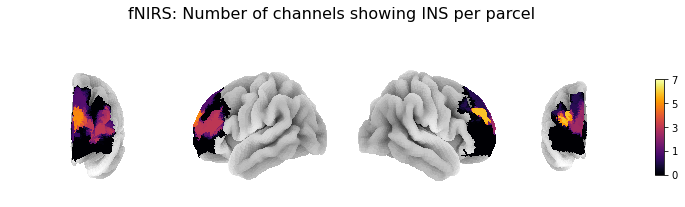

In [14]:
# get fnirs results
fnirs_res, fnirs_vols, fnirs_coord = fnirs_result(
    data  =pd.read_csv(join(wd, 'fnirs_coordinates.csv')), # spreadsheet with fixed column names (see script)
    atlas =load_img(join(wd, 'atlases', 'Schaefer200-7_TianS1_2mm.nii.gz')), # whole-brain parcellation
    labels=pd.read_csv(join(wd, 'atlases', 'Schaefer200-7_TianS1_2mm.csv'), 
                           names=['idx', 'label'])) # parcel labels with fixed columns names

# save
fnirs_res.to_csv(join(wd, 'fnirs_atlas_result.csv'), index=False)
fnirs_coord.to_csv(join(wd, 'fnirs', 'fnirs_coordinates_nearest.csv'), index=False)
fnirs_vols[0].to_filename(join(wd, 'fnirs', 'fnirs_atlas_syncChannels.nii.gz'))
fnirs_vols[1].to_filename(join(wd, 'fnirs', 'fnirs_atlas_ratioSyncAllChannelsSubj.nii.gz'))

# plot on surface (note: continous interpolation, only for visualization purpose)
f, axs = plt.subplots(1, 4, subplot_kw=dict(projection='3d'), figsize=(12,3.5))
f.suptitle('fNIRS: Number of channels showing INS per parcel', fontsize=16)
plot_surface_roi(fnirs_vols[0], cmap='inferno', hemi='left', view='anterior',fig=f, ax=axs[0])
plot_surface_roi(fnirs_vols[0], cmap='inferno', hemi='left', view='lateral', fig=f, ax=axs[1])
plot_surface_roi(fnirs_vols[0], cmap='inferno', hemi='right', view='lateral',fig=f, ax=axs[2])
plot_surface_roi(fnirs_vols[0], cmap='inferno', hemi='right', view='anterior', fig=f, ax=axs[3], legend=True)
for a in f.axes: a.dist = 6.35